## Los datos
- Grupo
- Sexo
- Edad
- Modo_Llegada
- Lesión
- Queja_Principal
- Estado_Mental
- Dolor
- Dolor_NRS
- SBP
- DBP
- HR
- RR
- BT
- Saturación
- KTAS_Enfermera
- Diagnóstico_Urgencias
- Disposición
- KTAS_Experto
- Grupo_Error
- Duración_Estancia_Min
- Duración_KTAS_Min
- Error_Triaje


In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D # for 3D plots

### 1. Cargar los datos

In [147]:
datos=pd.read_csv('./data/202420_Laboratorio 2 - Agrupación_202420_Laboratorio_2_-_Agrupación_data.csv', sep=',', encoding = 'utf-8', index_col=0)

In [148]:
datos.shape

(1000, 22)

In [149]:
datos.dtypes

Sexo                          int64
Edad                          int64
Modo_Llegada                  int64
Lesion                        int64
Queja_Principal              object
Estado_Mental                 int64
Dolor                         int64
dolor_NRS                    object
SBP                         float64
DBP                         float64
HR                          float64
RR                          float64
BT                          float64
Saturacion                  float64
KTAS_enfermera                int64
Diagnostico_En_Urgencias     object
Disposicion                   int64
KTAS_experto                  int64
Grupo_De_Error                int64
Duracion_Estancia_Min         int64
Duracion_KTAS_Min            object
Error_Triaje                  int64
dtype: object

In [150]:
datos.sample(5)

,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,DBP,...,BT,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje
Grupo,,,,,,,,,,,,,,,,,,,,,
2,2,65,2,1,dysarthria,2,0,#BOÞ!,160.0,90.0,...,37.2,99.0,4,Cerebral infarction due to unspecified occlusi...,2,3,5,572,"4,00",2
2,1,82,2,1,dyspnea,1,1,4,140.0,90.0,...,36.4,96.0,2,"Asthma, unspecified",2,2,0,1101,"2,00",0
2,2,62,2,1,dizziness,1,0,#BOÞ!,110.0,70.0,...,36.0,98.0,3,Dizziness and giddiness,2,3,0,255,"1,00",0
2,2,49,3,2,oral bleeding,1,1,4,120.0,70.0,...,36.6,98.0,4,Traumatic secondary and recurrent haemorrhage,1,4,0,188,"3,00",0
2,1,22,3,1,right upper abdominal pain,1,1,5,100.0,60.0,...,36.2,98.0,4,"Female pelvic inflammatory disease, unspecified",1,3,4,698,"3,00",2


### 2. Entendimiento de los datos

In [151]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 2 to 1
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Sexo                      1000 non-null   int64  
 1   Edad                      1000 non-null   int64  
 2   Modo_Llegada              1000 non-null   int64  
 3   Lesion                    1000 non-null   int64  
 4   Queja_Principal           1000 non-null   object 
 5   Estado_Mental             1000 non-null   int64  
 6   Dolor                     1000 non-null   int64  
 7   dolor_NRS                 1000 non-null   object 
 8   SBP                       983 non-null    float64
 9   DBP                       979 non-null    float64
 10  HR                        988 non-null    float64
 11  RR                        985 non-null    float64
 12  BT                        989 non-null    float64
 13  Saturacion                444 non-null    float64
 14  KTAS_enfermera  

In [152]:
datos.describe()

,Sexo,Edad,Modo_Llegada,Lesion,Estado_Mental,Dolor,SBP,DBP,HR,RR,BT,Saturacion,KTAS_enfermera,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Error_Triaje
count,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,983.000000,979.000000,988.000000,985.000000,989.000000,444.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.514000,53.892000,2.811000,1.2000,1.103000,0.562000,133.485249,79.566905,84.400810,19.450761,36.562993,97.047297,3.328000,1.610000,3.260000,0.569000,12792.480000,0.253000
std,0.500054,19.826483,0.796186,0.4002,0.431946,0.496389,27.156136,15.174593,16.297428,2.069882,0.519699,4.761112,0.862067,1.161572,0.865534,1.587375,87721.151446,0.630387
min,1.000000,16.000000,1.000000,1.0000,1.000000,0.000000,50.000000,31.000000,32.000000,14.000000,35.000000,20.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,36.000000,2.000000,1.0000,1.000000,0.000000,114.000000,70.000000,73.000000,18.000000,36.200000,97.000000,3.000000,1.000000,3.000000,0.000000,132.750000,0.000000
50%,2.000000,56.000000,3.000000,1.0000,1.000000,1.000000,130.000000,80.000000,82.000000,20.000000,36.500000,98.000000,3.000000,1.000000,3.000000,0.000000,270.500000,0.000000
75%,2.000000,70.250000,3.000000,1.0000,1.000000,1.000000,150.000000,90.000000,96.000000,20.000000,36.800000,99.000000,4.000000,2.000000,4.000000,0.000000,620.000000,0.000000
max,2.000000,94.000000,7.000000,2.0000,4.000000,1.000000,275.000000,160.000000,148.000000,30.000000,39.800000,100.000000,5.000000,7.000000,5.000000,9.000000,709510.000000,2.000000


In [153]:
def calcularEWS(registro):
    total = 0
    
    # Frecuencia respiratoria (RR)
    if registro['RR'] <= 8:
        total += 2
    elif 9 <= registro['RR'] <= 14:
        total += 0
    elif 15 <= registro['RR'] <= 20:
        total += 1
    elif 21 <= registro['RR'] <= 29:
        total += 2
    elif registro['RR'] >= 30:
        total += 3
    
    # Presión arterial sistólica (SBP)
    if registro['SBP'] <= 70:
        total += 3
    elif 71 <= registro['SBP'] <= 80:
        total += 2
    elif 81 <= registro['SBP'] <= 100:
        total += 1
    elif 101 <= registro['SBP'] <= 199:
        total += 0
    elif registro['SBP'] >= 200:
        total += 2

    # Frecuencia cardíaca (HR)
    if registro['HR'] <= 40:
        total += 2
    elif 41 <= registro['HR'] <= 50:
        total += 1
    elif 51 <= registro['HR'] <= 100:
        total += 0
    elif 101 <= registro['HR'] <= 110:
        total += 1
    elif 111 <= registro['HR'] <= 129:
        total += 2
    elif registro['HR'] >= 130:
        total += 3

    # Temperatura corporal (BT)
    if registro['BT'] < 35.0:
        total += 2
    elif 35.0 <= registro['BT'] <= 38.4:
        total += 0
    elif 38.5 <= registro['BT']:
        total += 2

    # Saturación de oxígeno (Saturacion)
    if registro['Saturacion'] <= 91:
        total += 3
    elif 92 <= registro['Saturacion'] <= 93:
        total += 2
    elif 94 <= registro['Saturacion'] <= 95:
        total += 1

    # Nivel de conciencia
    if registro['Estado_Mental'] == 1:
        total += 0
    elif registro['Estado_Mental'] == 2:
        total += 1
    elif registro['Estado_Mental'] == 3:
        total += 2
    elif registro['Estado_Mental'] == 4:
        total += 3
    return total

datos['EWS'] = datos.apply(calcularEWS, axis=1)
print(datos.head())

       Sexo  Edad  Modo_Llegada  Lesion  Queja_Principal  Estado_Mental  \
Grupo                                                                     
2         2    49             2       1  ant. chest pain              1   
2         2    30             4       1         headache              1   
2         1    61             3       2  ant. chest pain              1   
2         2    61             3       1         headache              1   
1         2    67             3       1    fever & chill              1   

       Dolor dolor_NRS    SBP   DBP  ...  Saturacion  KTAS_enfermera  \
Grupo                                ...                               
2          1         2  150.0  90.0  ...        98.0               2   
2          1         4  140.0  80.0  ...        99.0               3   
2          1         3  100.0  60.0  ...        98.0               4   
2          1         4  120.0  70.0  ...        99.0               4   
1          0     #BOÞ!  143.0  70.0  ...  

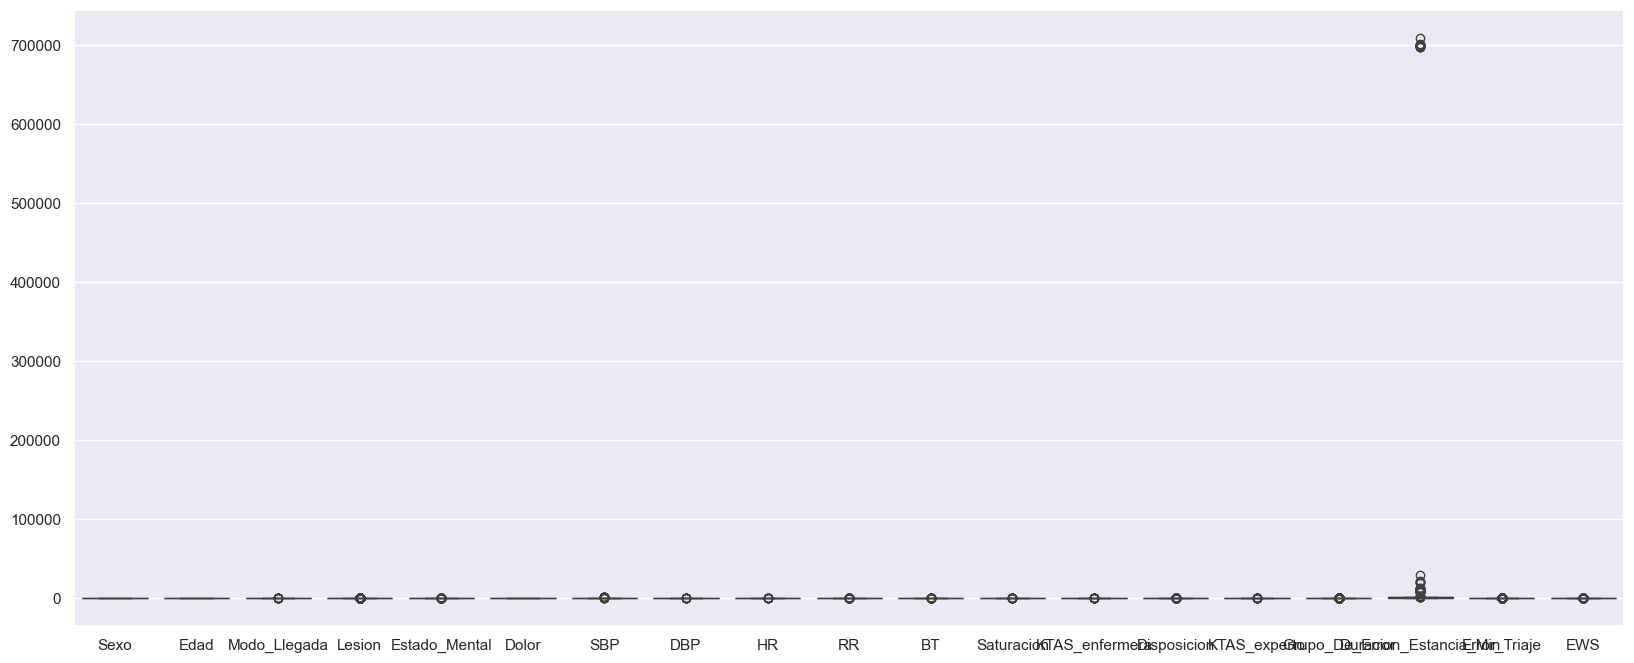

In [154]:
#Visualización de todas las variables numéricas
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=datos, orient="v")

In [155]:
name_cols_float = datos.select_dtypes(include = ['float']).columns
name_cols_int = datos.select_dtypes(include = ['int64']).columns
name_cols_int

Index(['Sexo', 'Edad', 'Modo_Llegada', 'Lesion', 'Estado_Mental', 'Dolor',
       'KTAS_enfermera', 'Disposicion', 'KTAS_experto', 'Grupo_De_Error',
       'Duracion_Estancia_Min', 'Error_Triaje', 'EWS'],
      dtype='object')

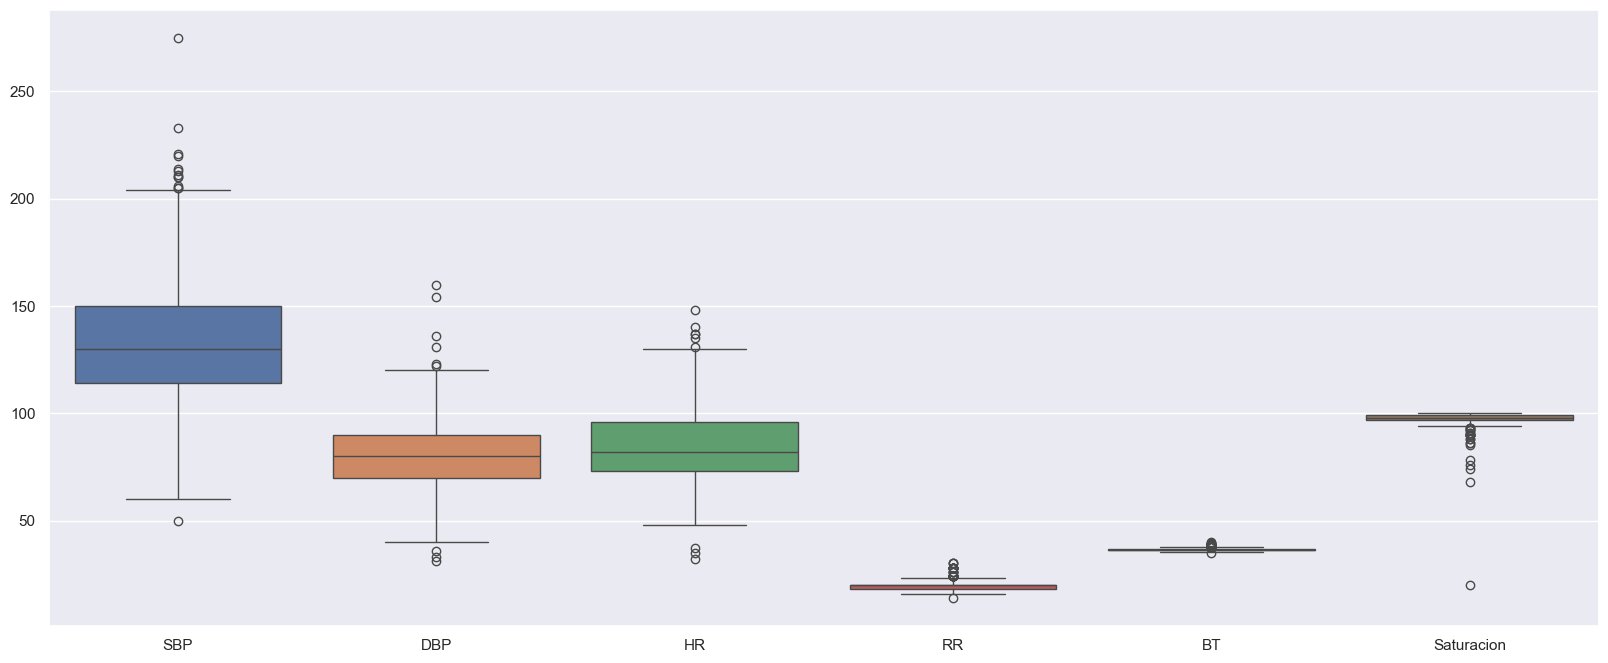

In [156]:
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=datos[name_cols_float], orient="v")

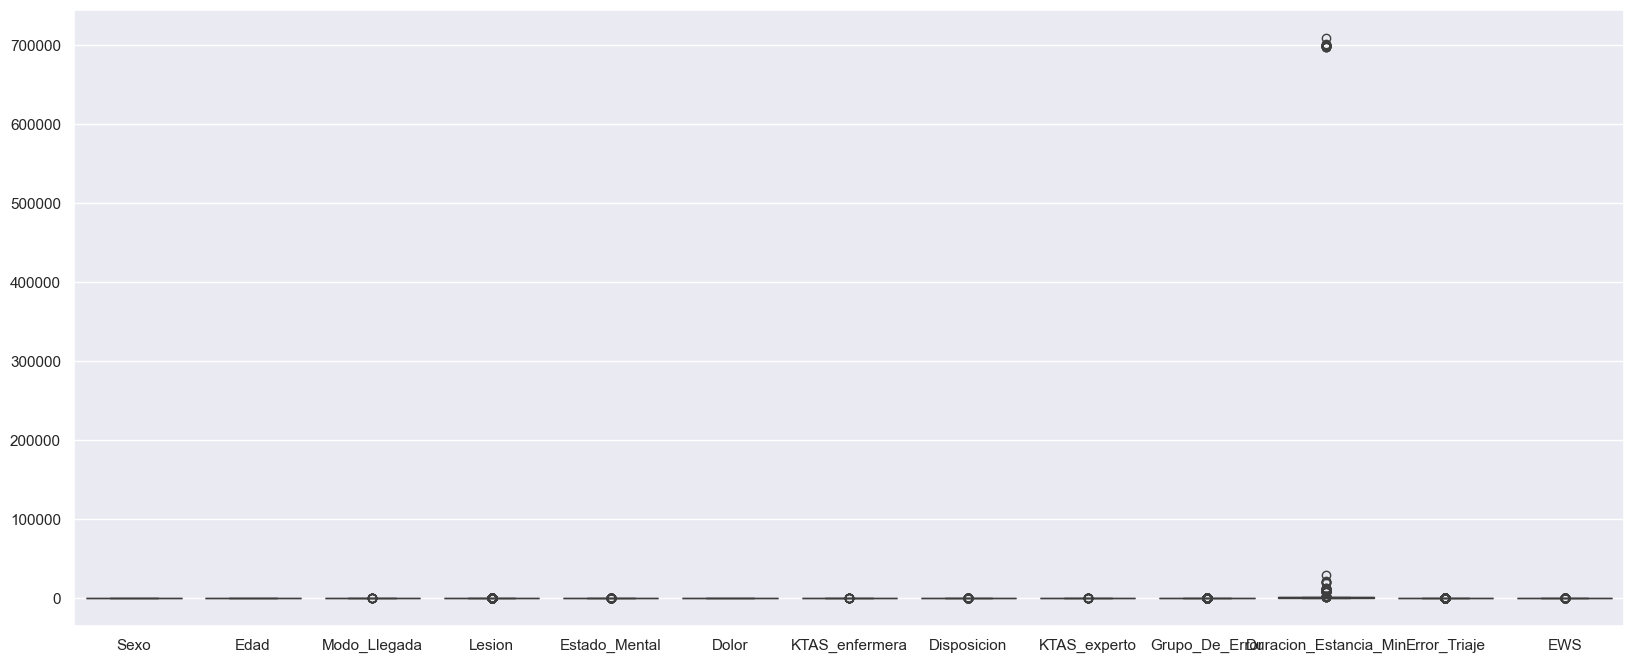

In [157]:
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=datos[name_cols_int], orient="v")

In [158]:
name_cols_non_number = datos.select_dtypes(include = ['object']).columns
name_cols_non_number

Index(['Queja_Principal', 'dolor_NRS', 'Diagnostico_En_Urgencias',
       'Duracion_KTAS_Min'],
      dtype='object')

In [159]:
datos.Queja_Principal.sample(10)

Grupo
2       Sensory, Decreased
2    whirling type vertigo
1             hematochezia
2                 RUQ pain
2                 headache
2                 abd pain
1        facial palsy left
1          pelvic pain, Lt
1           Motor weakness
1              pain, flank
Name: Queja_Principal, dtype: object

In [160]:
datos[name_cols_non_number].describe()

,Queja_Principal,dolor_NRS,Diagnostico_En_Urgencias,Duracion_KTAS_Min
count,1000,1000,999,1000
unique,347,11,489,335
top,abd pain,#BOÞ!,Acute gastroenteritis,"2,00"
freq,62,440,39,133


In [161]:
datos[name_cols_non_number].sample(15)

,Queja_Principal,dolor_NRS,Diagnostico_En_Urgencias,Duracion_KTAS_Min
Grupo,,,,
1,general weakness,#BOÞ!,Muscle weakness other,"17,37"
1,??? ? ???,3,Benign prostatic hyperplasia with obstruction,"3,73"
1,abd pain,3,Acute peritonitis,"8,00"
1,right forearm burn,2,"Burn of hand, firts degree dorsum","3,95"
1,dizziness,#BOÞ!,Gallbladder cancer,"5,38"
2,AVF site bleeding,#BOÞ!,"Chronic kidney disease, unspecified","4,00"
2,Lt flank pain,5,"Chronic kidney disease, unspecified","3,00"
1,diarrhea,#BOÞ!,Acute gastroenteritis,"10,02"
1,FB in pharynx,3,Foreign body in throat food,"5,92"


#### Análisis de completitud

In [162]:
datos.isnull().sum() / datos.shape[0]

Sexo                        0.000
Edad                        0.000
Modo_Llegada                0.000
Lesion                      0.000
Queja_Principal             0.000
Estado_Mental               0.000
Dolor                       0.000
dolor_NRS                   0.000
SBP                         0.017
DBP                         0.021
HR                          0.012
RR                          0.015
BT                          0.011
Saturacion                  0.556
KTAS_enfermera              0.000
Diagnostico_En_Urgencias    0.001
Disposicion                 0.000
KTAS_experto                0.000
Grupo_De_Error              0.000
Duracion_Estancia_Min       0.000
Duracion_KTAS_Min           0.000
Error_Triaje                0.000
EWS                         0.000
dtype: float64

### 3. Preparación de datos

In [163]:
datos=datos[datos["Duracion_Estancia_Min"]<=850]

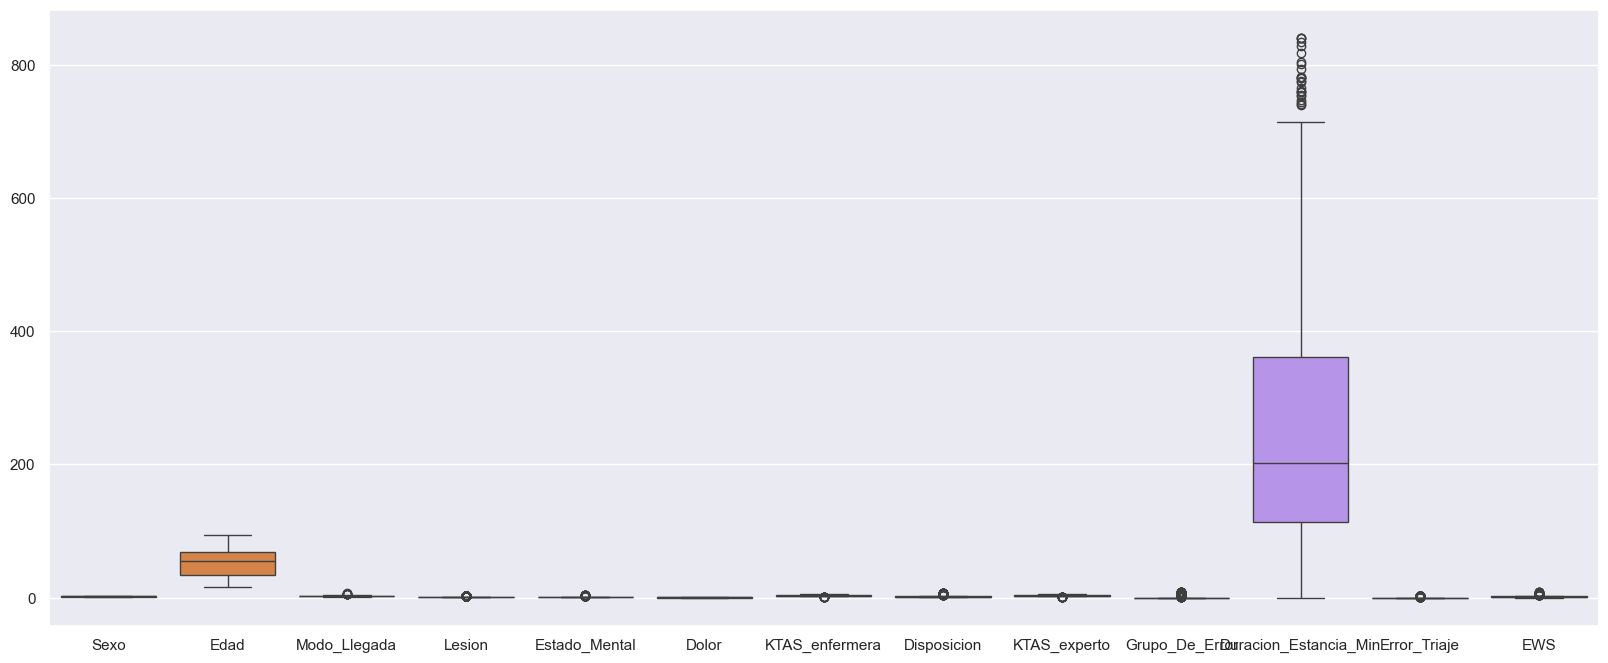

In [164]:
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=datos[name_cols_int], orient="v")

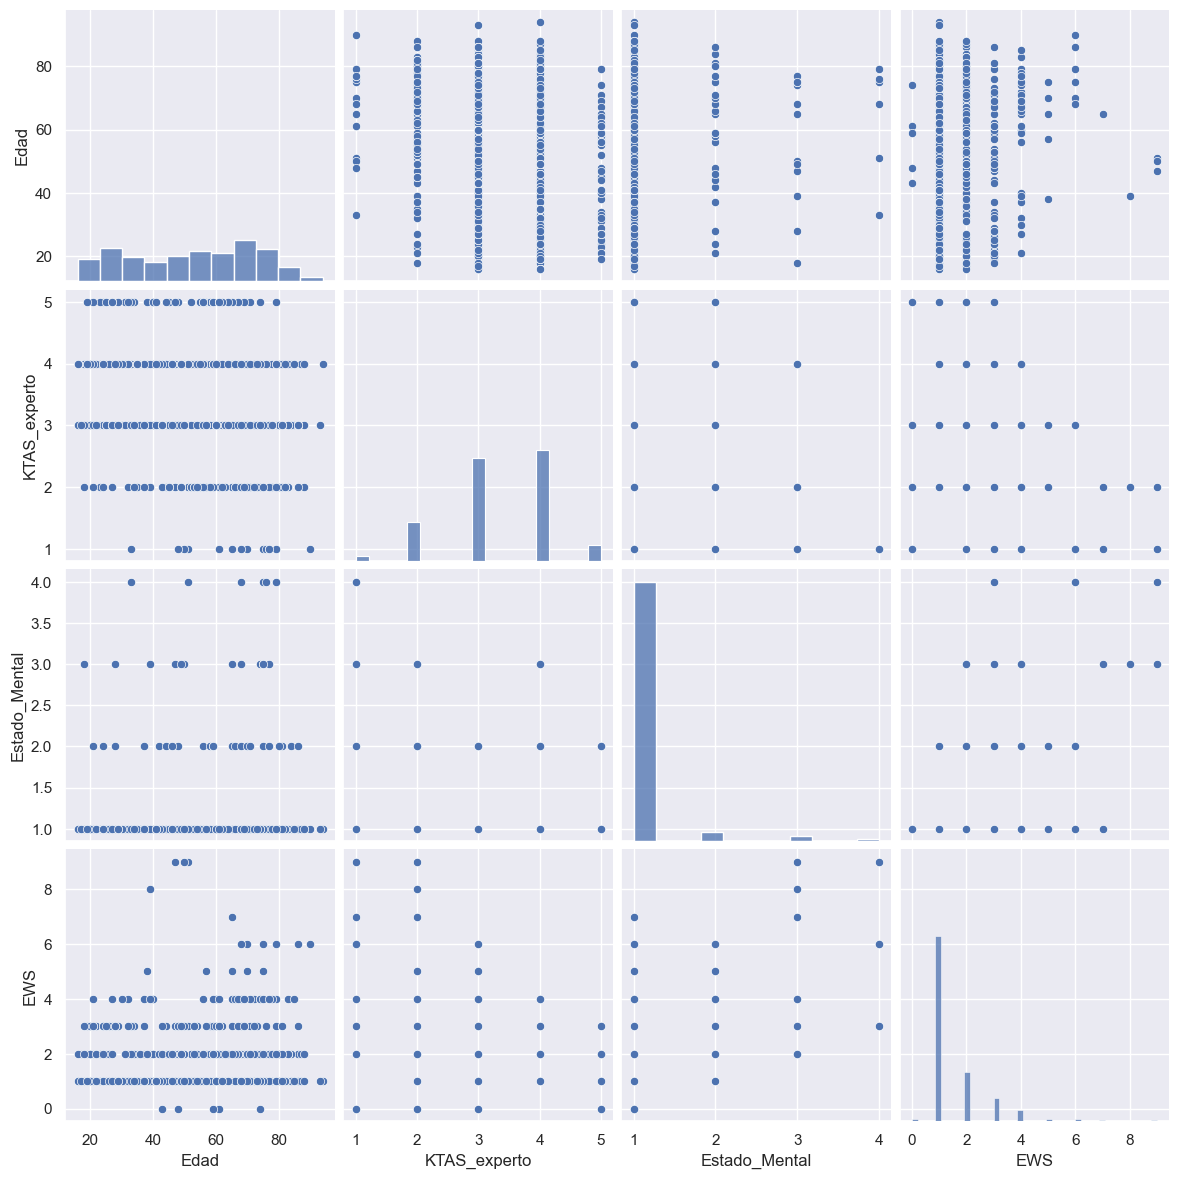

In [165]:
name_cols = ['Edad', 'KTAS_experto', 'Estado_Mental', 'EWS', 'dolor_NRS']
datos_cols_selec = datos[name_cols].copy()
print(datos_cols_selec.head())
sns.pairplot(datos_cols_selec, height=3,kind='scatter')

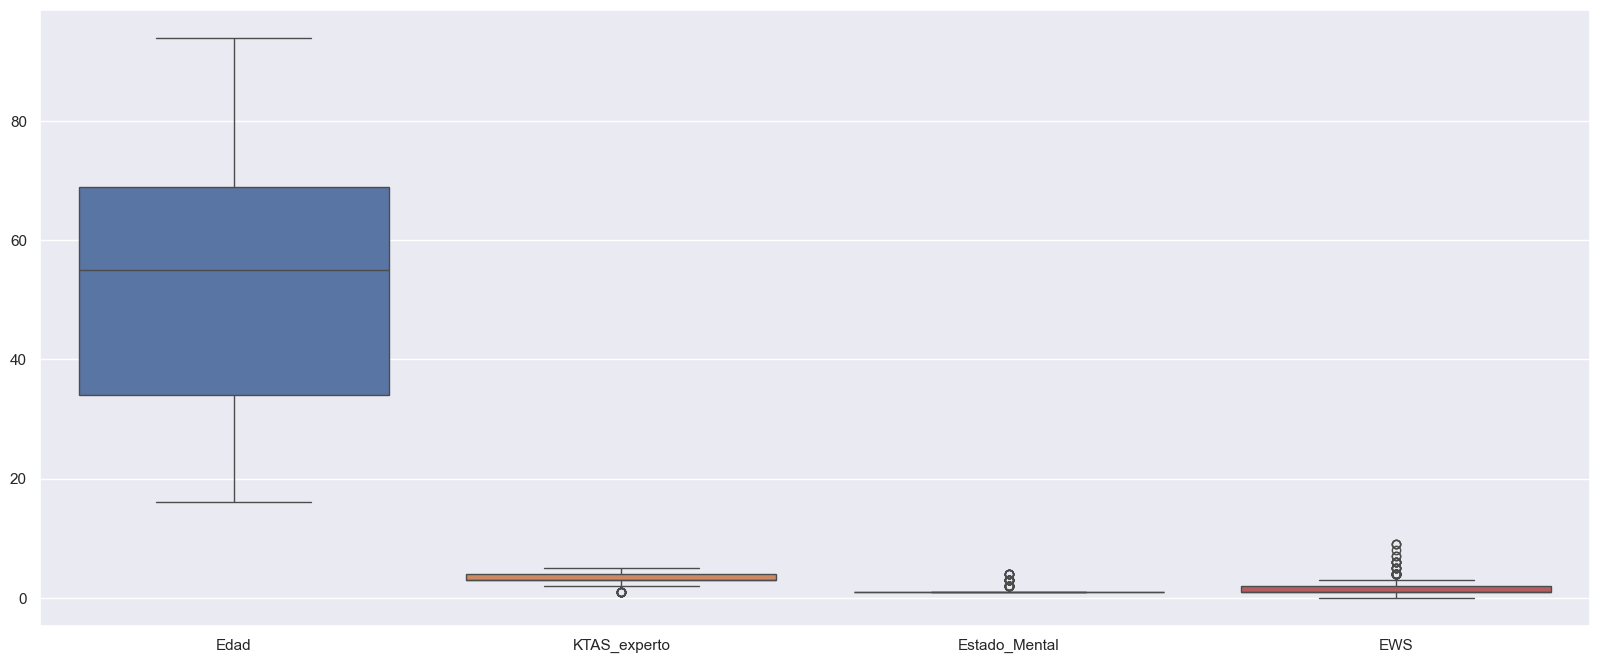

In [166]:
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=datos_cols_selec, orient="v")

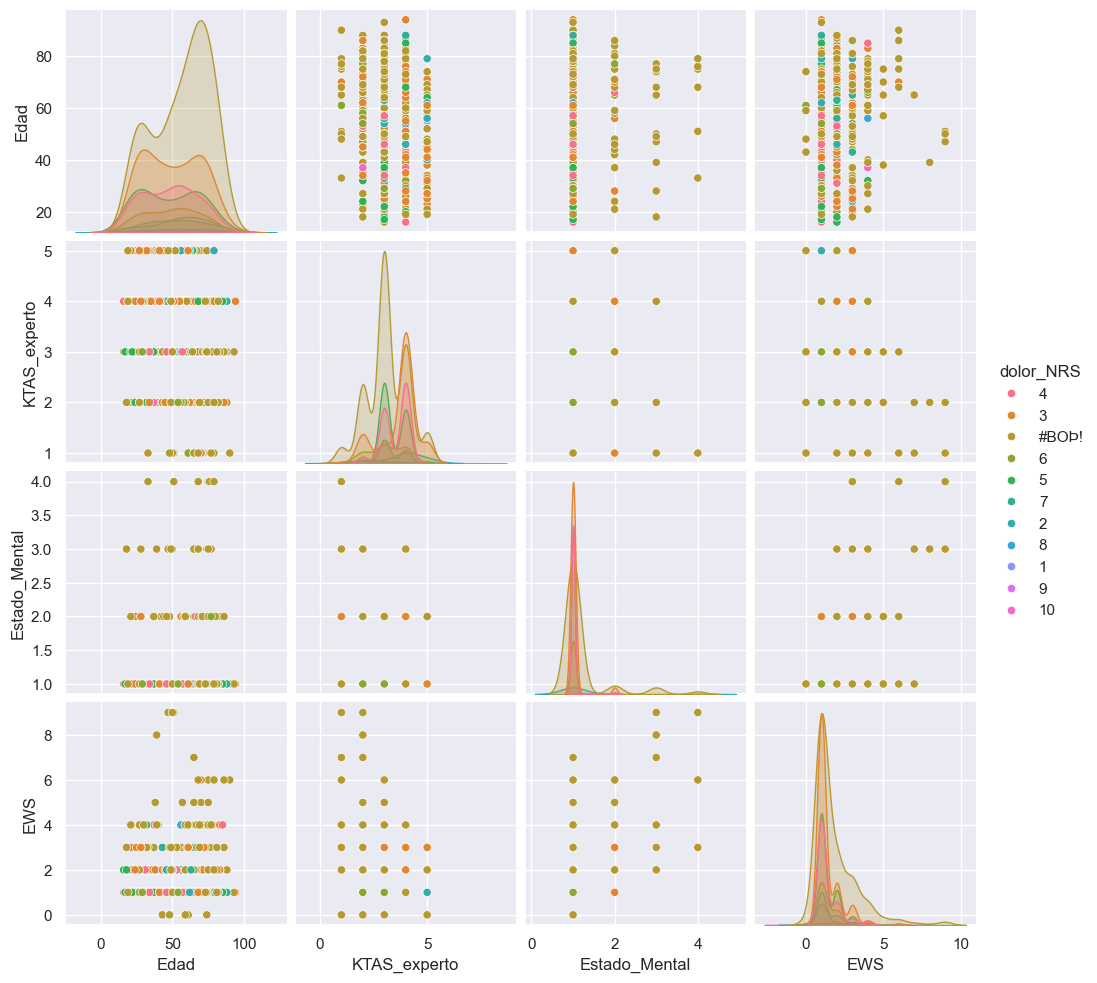

In [169]:
sns.pairplot(data=datos_cols_selec, hue="dolor_NRS")

In [168]:
mms = MinMaxScaler()


datos_prep_norm = datos.copy()
datos_prep_norm[name_cols] = mms.fit_transform(datos[name_cols])
datos_prep_norm=datos_prep_norm[name_cols]
saved_cols = datos_prep_norm.columns

datos_prep_norm = pd.DataFrame(datos_prep_norm, columns =saved_cols)
print(datos_prep_norm.head())

ValueError: could not convert string to float: '#BOÞ!'

In [ ]:
datos_prep_norm.describe()

In [127]:
def plot_distortion(data,
                    k_min=1, 
                    k_max=11,
                    ylabel = 'Distortion',
                    xlabel = 'Number of clusters',
                    title = 'Distortion Plot'):
    '''
    Graficar el codo de los clusters
    
    Parametros
    ----------
    data : np.array
        El arreglo con los datos
    k_min : int
        Valor mínimo para k
    k_max : int
        Valor máximo para k
    xlabel : string
        La etiqueta del eje x
    ylabel  string
        La etiqueta del eje y    
    title : string
        El titulo de la gráfica  
    '''
    distortions = []
    for i in range(k_min, k_max):
        km = KMeans(n_clusters=i,
                 init='k-means++',
                 n_init=10,
                 max_iter=300,
                 random_state=0)
        km.fit(data)
        distortions.append(km.inertia_)
    plt.plot(range(k_min,k_max), distortions, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [ ]:
plot_distortion(datos_prep_norm,1,11)

In [ ]:
N_clusters=4
kmeans = KMeans(n_clusters=N_clusters, random_state=0) 
kmeans = kmeans.fit(datos_prep_norm)

In [ ]:
labels = kmeans.labels_
datos_prep_norm['Cluster'] = labels

cluster_distrib = datos_prep_norm['Cluster'].value_counts()

fig=plt.figure(figsize=(12,8))
sns.barplot(x=cluster_distrib.index, y=cluster_distrib.values, color='b')

In [ ]:
cols_number = datos_prep_norm.to_numpy()
datos_prep_norm.groupby('Cluster').count()

In [ ]:
plt.scatter(cols_number[kmeans.labels_ == 0, 0], cols_number[kmeans.labels_ == 0, 1], s = 100, marker='v', c = 'red', label = 'Cluster 1')
plt.scatter(cols_number[kmeans.labels_ == 1, 0], cols_number[kmeans.labels_ == 1, 1], s = 100, marker='o', c = 'blue', label = 'Cluster 2')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Clusters')
plt.xlabel(name_cols[0])
plt.ylabel(name_cols[1])
plt.legend()
plt.show()

In [139]:
def plot_silhouette(data, 
                    labels,
                   ylabel = 'Grupos',
                   xlabel = "Coeficiente de silueta",
                   title = 'Gráfica de silueta'):
    '''
    Graficar la silueta de los clusters
    
    Parametros
    ----------
    data : np.array
        El arreglo con los datos
    labels : np.array
        El arreglo con las etiquetas correspondientes
    ylabel  string
        La etiqueta del eje y
    xlabel : string
        La etiqueta del eje x
    title : string
        El titulo de la gráfica        
    '''
    cluster_labels = np.unique(labels)
    print(cluster_labels)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(data,
                                        labels,
                                        metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[labels == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper),
                        c_silhouette_vals,
                        height=1.0,
                        edgecolor='none',
                        color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg,
                color="red",
                linestyle="--")
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

In [ ]:
plot_silhouette(data = datos_prep_norm, 
                labels = kmeans.labels_, 
                ylabel = 'Modelo de dos Agrupaciones')